In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('BNData.csv')

# Handle missing values
data.fillna(data.mean(), inplace=True)

# Ensure 'Outcome' column exists
assert 'Outcome' in data.columns, "The 'Outcome' column is missing from the dataset!"

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Discretize based on training dataset
def discretize_column(train, test, col, bins=5):
    labels = range(bins)
    train[col] = pd.cut(train[col], bins=bins, labels=labels)
    test[col] = pd.cut(test[col], bins=bins, labels=labels)

for col in ['Glucose', 'BMI', 'Age', 'DPF', 'Pregnancies', 'BloodPressure', 'Insulin', 'SkinThickness']:
    discretize_column(train_data, test_data, col)

# Structure learning using Hill Climb Search and K2 (K2Score)
from pgmpy.estimators import K2Score

hc = HillClimbSearch(train_data)
best_model_dag = hc.estimate(scoring_method=K2Score(train_data))

# Print the structure learned
#print("Best Model Structure:", best_model_dag.edges())

# Calculate correlation matrix for reference
correlation_matrix = train_data.corr()

# Add edges dynamically based on correlation (if correlation > 0.3)
def add_edges_based_on_correlation(model, correlation_matrix, threshold=0.3):
    for col in correlation_matrix.columns:
        if abs(correlation_matrix['BloodPressure'][col]) > threshold and col != 'BloodPressure':
            # Add an edge from 'BloodPressure' to strongly correlated columns
            if not model.has_edge('BloodPressure', col):
                model.add_edge('BloodPressure', col)
    return model

# Convert DAG to BayesianNetwork and add edges if necessary
model = BayesianNetwork(best_model_dag.edges())

# Dynamically add edges based on correlation (optional, as needed)
model = add_edges_based_on_correlation(model, correlation_matrix)

# Train the model with the modified structure
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Perform inference
inference = VariableElimination(model)

# Predict outcomes
def predict_outcome(row):
    evidence = {col: min(max(row[col], 0), 4) for col in row.index if col != 'Outcome'}
    query_result = inference.map_query(variables=['Outcome'], evidence=evidence, show_progress=False)
    return query_result['Outcome']

# Apply the prediction function row-wise
test_data['Predicted'] = test_data.apply(predict_outcome, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(test_data['Outcome'], test_data['Predicted'])
print(f'Model Accuracy: {accuracy * 100:.2f}%')

  0%|          | 0/1000000 [00:00<?, ?it/s]

Best Model Structure: [('Pregnancies', 'SkinThickness'), ('Pregnancies', 'Glucose'), ('Pregnancies', 'BloodPressure'), ('Glucose', 'SkinThickness'), ('BloodPressure', 'SkinThickness'), ('BloodPressure', 'Glucose'), ('Insulin', 'SkinThickness'), ('Insulin', 'Glucose'), ('Insulin', 'BloodPressure'), ('Insulin', 'Outcome'), ('Insulin', 'Pregnancies'), ('BMI', 'SkinThickness'), ('BMI', 'Glucose'), ('BMI', 'BloodPressure'), ('BMI', 'Pregnancies'), ('DPF', 'SkinThickness'), ('DPF', 'Glucose'), ('DPF', 'BloodPressure'), ('DPF', 'Pregnancies'), ('Age', 'Pregnancies'), ('Age', 'SkinThickness'), ('Age', 'Glucose'), ('Age', 'Outcome'), ('Age', 'BloodPressure'), ('Outcome', 'SkinThickness'), ('Outcome', 'BMI'), ('Outcome', 'Glucose'), ('Outcome', 'BloodPressure'), ('Outcome', 'Pregnancies')]


c:\Users\Marinand\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:489: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()


Model Accuracy: 70.13%


Edges in the Graph: [('Pregnancies', 'SkinThickness'), ('Pregnancies', 'Glucose'), ('Pregnancies', 'BloodPressure'), ('Glucose', 'SkinThickness'), ('BloodPressure', 'SkinThickness'), ('BloodPressure', 'Glucose'), ('Insulin', 'SkinThickness'), ('Insulin', 'Glucose'), ('Insulin', 'BloodPressure'), ('Insulin', 'Outcome'), ('Insulin', 'Pregnancies'), ('Outcome', 'SkinThickness'), ('Outcome', 'BMI'), ('Outcome', 'Glucose'), ('Outcome', 'BloodPressure'), ('Outcome', 'Pregnancies'), ('BMI', 'SkinThickness'), ('BMI', 'Glucose'), ('BMI', 'BloodPressure'), ('BMI', 'Pregnancies'), ('DPF', 'SkinThickness'), ('DPF', 'Glucose'), ('DPF', 'BloodPressure'), ('DPF', 'Pregnancies'), ('Age', 'Pregnancies'), ('Age', 'SkinThickness'), ('Age', 'Glucose'), ('Age', 'Outcome'), ('Age', 'BloodPressure')]
Node Positions: {'Pregnancies': array([ 1.00000000e+00, -2.56551911e-09]), 'SkinThickness': array([0.76604444, 0.64278758]), 'Glucose': array([0.17364821, 0.98480773]), 'BloodPressure': array([-0.50000001,  0.86

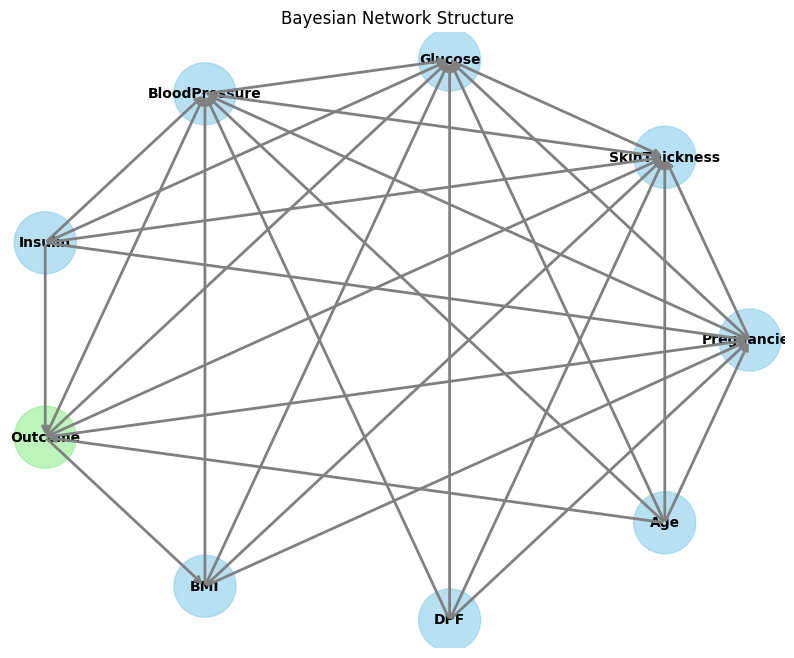

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Convert the model into a directed NetworkX graph
graph = model.to_directed()
# Print the edges in the graph
#print("Edges in the Graph:", list(graph.edges()))


# Generate positions for nodes using spring layout
pos = nx.kamada_kawai_layout(graph)
# Print node positions to understand the layout
#print("Node Positions:", pos)

# Plot the Bayesian network structure
plt.figure(figsize=(10, 8))

# Draw nodes with distinct color for Outcome node
node_colors = ['lightgreen' if node == 'Outcome' else 'skyblue' for node in graph.nodes()]
nx.draw_networkx_nodes(graph, pos, node_size=2000, node_color=node_colors, alpha=0.6)

# Draw labels
nx.draw_networkx_labels(graph, pos, font_size=10, font_weight='bold')

# Manually draw edges with arrows and optional weights
edge_weights = {}  # Example: Add weight extraction logic if needed
for edge in graph.edges():
    start, end = pos[edge[0]], pos[edge[1]]
    weight = edge_weights.get(edge, 1)  # Default weight is 1
    plt.annotate("", xy=end, xytext=start,
                 arrowprops=dict(arrowstyle="->", color="gray", lw=weight*2))  # Adjust lw for weight

plt.title('Bayesian Network Structure')
plt.axis('off')  # Hide axes
plt.show()

In [11]:
# Example Input 1
example_input1 = {
    'Pregnancies': 3,
    'Glucose': 130,           # mg/dL
    'BloodPressure': 75,      # mm Hg
    'BMI': 30,                # BMI
    'Insulin': 150,           # Serum insulin level
    'SkinThickness': 35,      # Triceps skinfold measurement (mm)
    'Age': 45,                # Years
    'DPF': 0.8                # Diabetes Pedigree Function
}

# Discretize the example input using the same bins as in the training data
def discretize_value(value, column):
    # Handle NaN values by checking if the value is NaN
    if pd.isna(value):
        return -1  # You can replace -1 with another default value if needed
    
    # Use the sorted unique values from the training data as bins
    sorted_bins = sorted(train_data[column].unique())
    
    # Adjust the number of labels to be one less than the number of bins
    num_labels = len(sorted_bins) - 1
    labels = range(num_labels)
    
    # Return the discretized value, handling out-of-range values properly
    discretized_value = pd.cut([value], bins=sorted_bins, labels=labels, right=False)
    if discretized_value.isna().any():  # Check if the value falls outside the bins
        return -1  # You can set a default label here
    return discretized_value[0]

# Discretize the example input
discretized_input1 = {col: discretize_value(val, col) for col, val in example_input1.items()}

# Convert the example input into a DataFrame for prediction
example_input_df1 = pd.DataFrame([discretized_input1])

# Fill any NaN values with a default value (e.g., -1 or median)
example_input_df1 = example_input_df1.fillna(-1)

# Prepare the evidence in the correct format
def prepare_evidence(row):
    # Make sure evidence is mapped properly for prediction
    evidence = {col: int(row[col]) for col in row.index if col != 'Outcome'}
    return evidence

# Prepare the evidence for the example input
evidence1 = prepare_evidence(example_input_df1.iloc[0])

# Perform prediction using the trained model
example_prediction1 = inference.map_query(variables=['Outcome'], evidence=evidence1, show_progress=False)

# Print the output
print(f"Predicted Outcome: {example_prediction1['Outcome']}")

Predicted Outcome: 1


In [14]:
# Example Input 2
example_input2 = {
    'Pregnancies': 1,
    'Glucose': 70,           # mg/dL
    'BloodPressure': 70,     # mm Hg
    'BMI': 22,               # BMI
    'Insulin': 90,           # Serum insulin level
    'SkinThickness': 25,     # Triceps skinfold measurement (mm)
    'Age': 32,               # Years
    'DPF': 0.2               # Diabetes Pedigree Function
}

# Discretize the example input using the same bins as in the training data
def discretize_value(value, column):
    # Handle NaN values by checking if the value is NaN
    if pd.isna(value):
        return -1  # You can replace -1 with another default value if needed
    
    # Use the sorted unique values from the training data as bins
    sorted_bins = sorted(train_data[column].unique())
    
    # Adjust the number of labels to be one less than the number of bins
    num_labels = len(sorted_bins) - 1
    labels = range(num_labels)
    
    # Return the discretized value, handling out-of-range values properly
    discretized_value = pd.cut([value], bins=sorted_bins, labels=labels, right=False)
    if discretized_value.isna().any():  # Check if the value falls outside the bins
        return -1  # You can set a default label here
    return discretized_value[0]

# Discretize the example input
discretized_input2 = {col: discretize_value(val, col) for col, val in example_input2.items()}

# Convert the example input into a DataFrame for prediction
example_input_df2 = pd.DataFrame([discretized_input2])

# Fill any NaN values with a default value (e.g., -1 or median)
example_input_df2 = example_input_df2.fillna(-1)

# Prepare the evidence in the correct format
def prepare_evidence(row):
    # Make sure evidence is mapped properly for prediction
    evidence = {col: int(row[col]) for col in row.index if col != 'Outcome'}
    return evidence

# Prepare the evidence for the example input
evidence2 = prepare_evidence(example_input_df2.iloc[0])

# Perform prediction using the trained model
example_prediction2 = inference.map_query(variables=['Outcome'], evidence=evidence2, show_progress=False)

# Print the output
print(f"Predicted Outcome: {example_prediction2['Outcome']}")

Predicted Outcome: 1
